# Masking in FFT estimators for P1D (emulate different z_q)

Let's now emulate the fact that not all lines of sight have the same z_q

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Define the FFT grid

In [2]:
# number of pixels (powers of two are usually good) for the whole FFT grid
N=2**10
# whole range of FFT grid (larger than the length of a given skewer)
L=1000
# pixel width 
dx = L/N
print('dx=',dx)
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
k = np.fft.fftfreq(N)*2*np.pi/dx

dx= 0.9765625


In [3]:
print('Nk =',k.shape)
print('Delta k =',k[1],2*np.pi/L)
print('k_Ny = ',-k[N//2],np.pi/dx)

Nk = (1024,)
Delta k = 0.006283185307179587 0.006283185307179587
k_Ny =  3.2169908772759483 3.2169908772759483


Setup the random number generator

In [4]:
# random seed
seed=1234
# setup random number generator using seed
gen = np.random.default_rng(seed)
# test the random number generator
gen.normal(size=1)

array([-1.60383681])

### Input power spectrum

The power spectrum will deteremine how much structure is there as a function of scale

In [5]:
def get_true_p1d(k,P0=1.0,k0=1,kF=10,r_SiIII=20,f_SiIII=0.05):
    """Define here your favorite power spectrum."""

    if np.any(k<0):
        raise ValueError('true_p1d should only receive non-zero values of k')

    # white noise at low-k
    P = P0*np.ones_like(k)

    # small enhancement at low-k
    P *= (1+k/k0)
    
    # suppressed at k0
    P *= 1/(1+(k/k0)**2)

    # further suppressed with a Gaussian at kF=10
    P *= np.exp(-(k/kF)**2)

    # SiIII(1207) contamination
    P *= (1+f_SiIII*np.sin(k*r_SiIII))
    
    return P

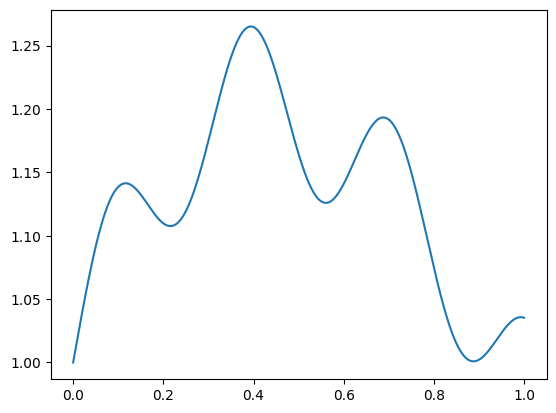

In [6]:
# linear plot
kplot=np.linspace(0,1,1000)
plt.plot(kplot,get_true_p1d(kplot))

(0.0001, 2)

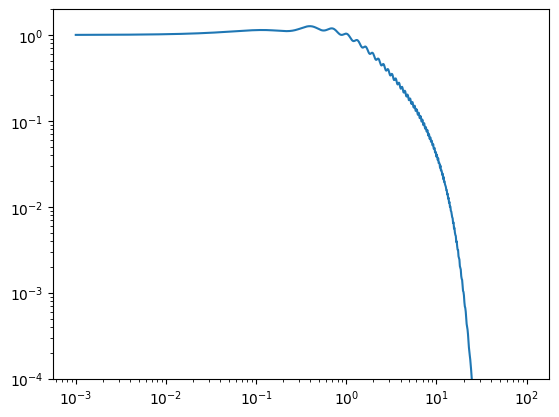

In [7]:
# log spacing plot
kplot=np.logspace(-3,2,1000)
plt.loglog(kplot,get_true_p1d(kplot))
plt.ylim(0.0001,2)

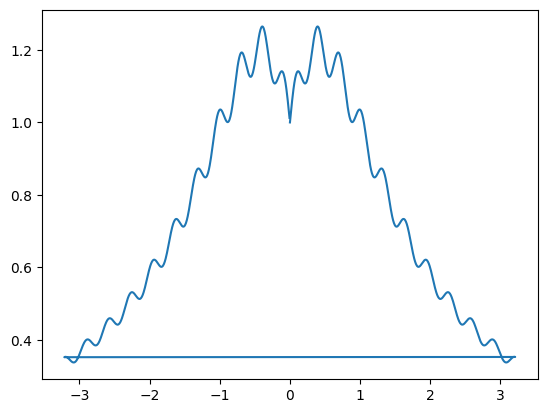

In [8]:
# evaluate true P1D for the plot
true_p1d=get_true_p1d(np.abs(k))
plt.plot(k,true_p1d)

### Generate random Gaussian skewers

Start by generating random Fourier modes

In [9]:
def get_gaussian_modes(gen,new_seed=None,debug=False):
    """Generate Gaussian random numbers for the Fourier modes of the grid."""

    if new_seed:
        new_gen = np.random.default_rng(new_seed)
    else:
        new_gen = gen

    if debug:
        print(new_gen.normal(size=1))
    
    # get power evaluated at each k (with correct normalisation, based on my notes)
    P = get_true_p1d(np.abs(k)) 
    norm = (N/dx)
    P *= norm

    # generate random Fourier modes
    modes = np.empty(N, dtype=complex)
    modes[:].real = new_gen.normal(size=N)
    modes[:].imag = new_gen.normal(size=N)
    
    # normalize to desired power (and enforce real for i=0, i=NF-1)
    modes[0] = modes[0].real * np.sqrt(P[0])
    modes[(N+1)//2] = modes[(N+1)//2].real * np.sqrt(P[(N+1)//2])
    modes[1:(N+1)//2] *= np.sqrt(0.5*P[1:(N+1)//2])    

    # remember that F(-k) = F^*(k)
    modes[(N+1)//2+1:]=np.conj(modes[1:(N+1)//2])[::-1]
    #modes[(N+1)//2+1:] *= np.sqrt(0.5*P[(N+1)//2+1:])    
    
    return modes

### Run on multiple skewers without masking

The squared amplitude of the Fourier modes should (on average!) agree with the input power spectrum

In [10]:
# generate many random fields
Nsk=int(1e6)
gen = np.random.default_rng(seed)

In [11]:
# measure P1D and variance
mean_p1d=np.zeros(N)
var_p1d=np.zeros(N)
for i in range(Nsk):
    modes=get_gaussian_modes(gen=gen,debug=False)
    p1d = abs(modes)**2
    mean_p1d += p1d
    var_p1d += p1d**2
# normalize them
mean_p1d /= Nsk
var_p1d /= Nsk
var_p1d -= mean_p1d**2
# compute error on mean
err_p1d = np.sqrt(var_p1d/Nsk)

In [12]:
# correct normalisation based on my notes
mean_p1d *= (dx/N)
err_p1d *= (dx/N)

Text(0.5, 0, 'k')

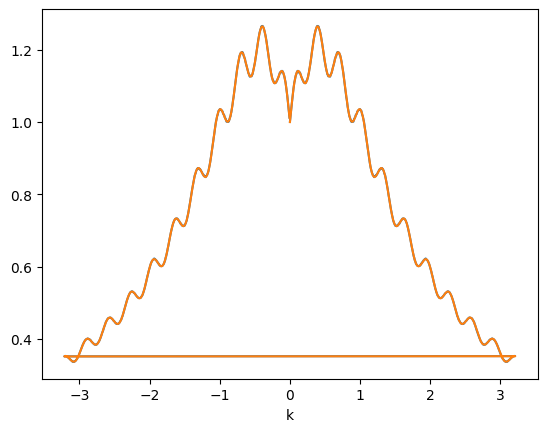

In [13]:
plt.plot(k,mean_p1d)
plt.plot(k,true_p1d)
plt.xlabel('k')

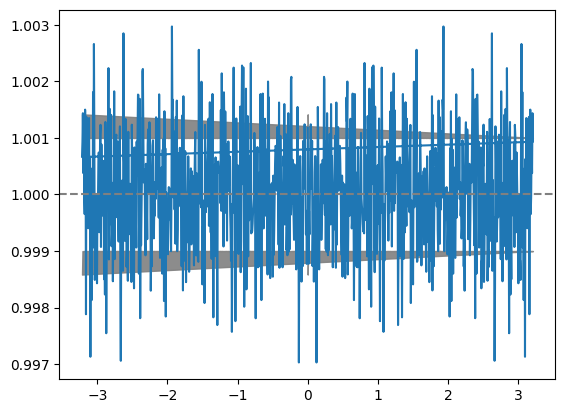

In [14]:
plt.plot(k,mean_p1d/true_p1d)
plt.fill_between(k,1-err_p1d/true_p1d,1+err_p1d/true_p1d,alpha=0.9,color='gray')
plt.axhline(y=1,ls='--',color='gray')

### Apply a different mask for each skewer (use 25% of pixels, starting from a different starting point)

In [15]:
# length of a given forest will be a quarter of the FFT grid
N4=N//4
x = dx*np.arange(N)

Text(0, 0.5, 'mask')

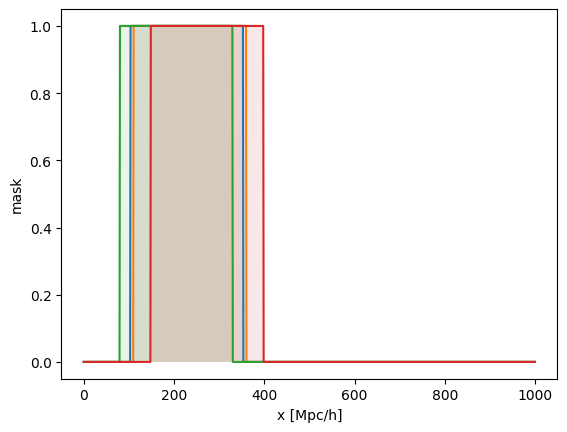

In [16]:
for i in range(4):
    # for simplicity, assume all forests start somewhere near the start of the box (they don't wrap around)
    istart=np.random.randint(low=0, high=N4)
    # create a mask for this particular skewer
    mask=np.zeros(N)
    mask[istart:istart+N4]=1
    plt.plot(x,mask)
    plt.fill_between(x,mask,alpha=0.1)
plt.xlabel('x [Mpc/h]')
plt.ylabel('mask')

In [17]:
# reset seed again
gen = np.random.default_rng(seed)
# measure P1D and variance
mean_masked_p1d=np.zeros(N)
var_masked_p1d=np.zeros(N)
# mean of |w_m|^2 (FFT of mask, squared)
w2_m=np.zeros(N)
for i in range(Nsk):
    # for simplicity, assume all forests start somewhere near the start of the box (they don't wrap around)
    istart=np.random.randint(low=0, high=N4)
    # create a mask for this particular skewer
    mask=np.zeros(N)
    mask[istart:istart+N4]=1
    # FFT of mask
    w_m = np.fft.fft(mask)
    w2_m += abs(w_m)**2
    # recompute modes
    modes=get_gaussian_modes(gen=gen,debug=False)    
    # FFT the modes to obtain the skewers
    deltas = np.fft.ifft(modes).real
    # mask the skewers
    deltas *= mask
    # and FFT again to obtain masked modes
    masked_modes=np.fft.fft(deltas)
    p1d = abs(masked_modes)**2
    mean_masked_p1d += p1d
    var_masked_p1d += p1d**2
# normalize mask
w2_m /= Nsk
# normalize them
mean_masked_p1d /= Nsk
var_masked_p1d /= Nsk
var_masked_p1d -= mean_masked_p1d**2
# compute error on mean
err_masked_p1d = np.sqrt(var_masked_p1d/Nsk)
# correct normalisation based on my notes
mean_masked_p1d *= (dx/N)
err_masked_p1d *= (dx/N)

(0.0, 0.5)

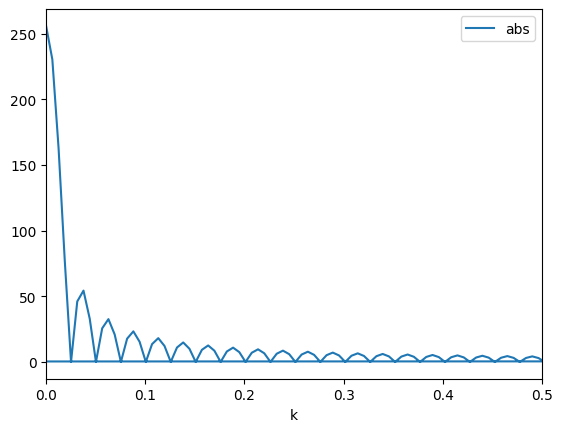

In [18]:
# plot FFT of mask (squared)
plt.plot(k,np.sqrt(w2_m),label='abs')
plt.legend()
plt.xlabel('k')
plt.xlim([0,0.5])

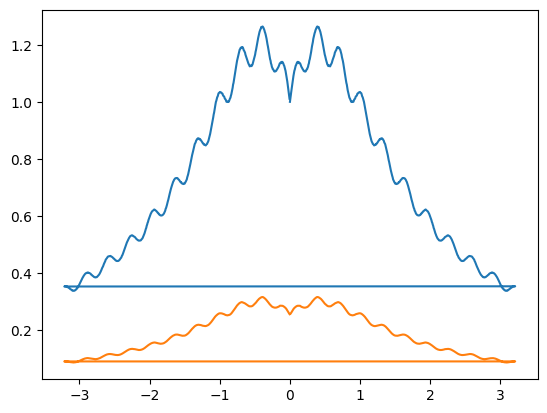

In [19]:
plt.plot(k,mean_p1d)
plt.plot(k,mean_masked_p1d)

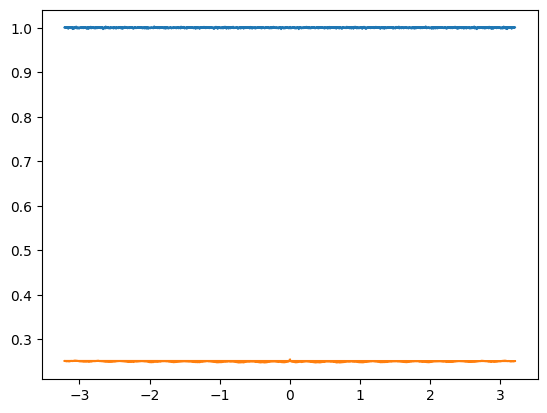

In [20]:
plt.plot(k,mean_p1d/true_p1d)
plt.plot(k,mean_masked_p1d/true_p1d)

In [21]:
norm=np.mean(mean_masked_p1d/mean_p1d)
print(norm)

0.25020488522273554


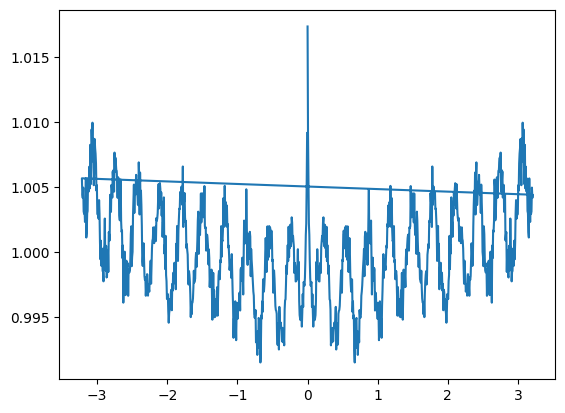

In [22]:
plt.plot(k,mean_masked_p1d/mean_p1d/norm)

### Try to convolve theory with mask

In [23]:
P_m = true_p1d / dx # < |delta_m|^2 >
xi_a = np.fft.ifft(P_m)
Q_a = np.fft.ifft(w2_m)

In [24]:
T_m = np.fft.fft(Q_a*xi_a)

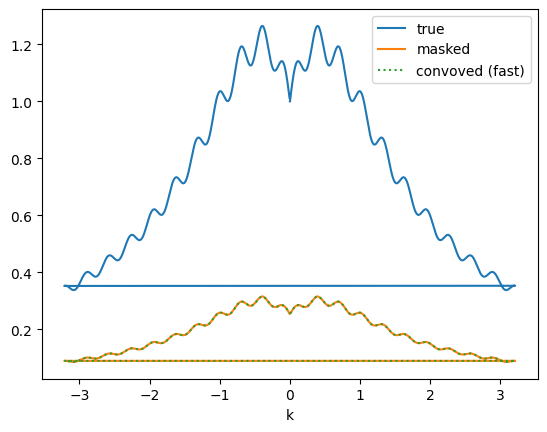

In [25]:
plt.plot(k,true_p1d,label='true')
plt.plot(k,mean_masked_p1d,label='masked')
#plt.plot(k,convolved_p1d/N/N,ls=':',label='convolved')
plt.plot(k,T_m.real*(dx/N),ls=':',label='convoved (fast)')
plt.xlabel('k')
plt.legend()

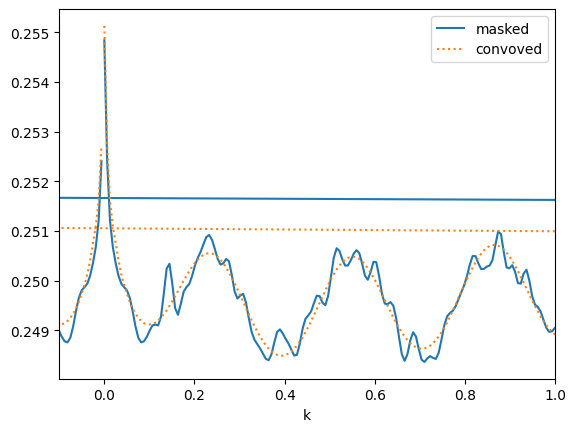

In [26]:
plt.plot(k,mean_masked_p1d/true_p1d,label='masked')
plt.plot(k,T_m.real*(dx/N)/true_p1d,ls=':',label='convoved')
plt.xlabel('k')
plt.xlim([-0.1,1])
plt.legend()